[Update Aug 2020 Mengyan Zhang]

This notebook implements regression on the first round results with repeated kfold.

# Pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Repeated Kfold: (n_repeated: 10; n_split/kfold: 5)
    - Kernel: weighted degree kernel with shift
        - kernel normalisation: centering and unit norm
        - lmer: number of substring [3,4,5,6]
    - Gaussian process regression 
        - alpha: scalar value add to diagonal 
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

# Key Notes

## Splitting over sequences

The training and testing data should be split in terms of sequences rather than samples, since we hope to have good predictions on unseen data. Similar idea as shown in [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html).

## Training with multiple labels vs. sample mean?

We now training with multiple labels, i.e. repeated sequences inputs with different labels (replicates).
It worth thinking whether it is equivalent to use the sample mean directly.


## Evaluate on samples vs sample mean?

For evaluation (on both training and testing predictions), we evaluate using "samples" or "averages", indicating by "eva_on" parameter. 

## What matters

The recommendations at the end it what matters, so once we choose certain parameters, we should focus on how it changes our recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
#     'Spectrum_Kernel': Spectrum_Kernel,
#     'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
#     'WD_Kernel': WeightedDegree_Kernel,
#     'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

In [3]:
Path = '../../data/Results_Microplate_partialTrue_normTrue_roundRep_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Unnamed: 16,Rep7,Rep8,Rep9,RBS6,index,Pred Mean,Pred Std,Pred UCB
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.433056,2.502155,2.315237,3.012905,2.917124,2.275329,2.575968,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.556251,1.654243,1.762146,1.790123,2.312790,1.959275,1.839138,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.603551,0.748674,0.921939,0.391285,0.503846,0.711231,0.646754,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.658359,1.874275,1.534988,1.546110,1.747116,1.232548,1.598899,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.545942,2.072095,1.386300,1.949759,1.774833,2.146898,1.812638,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
5,5,TGTAAGAAGGAGATATACAT,RBS_1by1_5,0.140540,0.113415,0.428642,0.083846,0.201247,0.349550,0.219540,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
6,6,TATAAGAAGGAGATATACAT,RBS_1by1_6,1.263922,1.295816,0.921114,0.849187,1.225523,1.667016,1.203763,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
7,7,TTGAAGAAGGAGATATACAT,RBS_1by1_8,1.506111,1.663509,NaN,2.009375,1.795683,2.231638,1.841263,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
8,8,TTAAAGAAGGAGATATACAT,RBS_1by1_9,0.457305,0.602012,1.358909,0.359069,0.281771,0.446837,0.584317,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN
9,9,TTTCAGAAGGAGATATACAT,RBS_1by1_10,1.470120,0.929044,0.610260,1.515338,1.210712,1.921650,1.276187,...,0,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN,NaN


In [4]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(266, 26)

(array([20., 42., 40., 31., 37., 42., 32., 11.,  8.,  3.]),
 array([-1.71864371e+00, -1.28918258e+00, -8.59721441e-01, -4.30260305e-01,
        -7.99169271e-04,  4.28661966e-01,  8.58123102e-01,  1.28758424e+00,
         1.71704537e+00,  2.14650651e+00,  2.57596765e+00]),
 <a list of 10 Patch objects>)

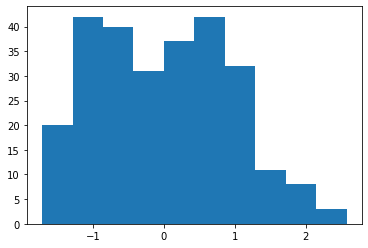

In [5]:
plt.hist(df['AVERAGE'])

# Repeated KFold 

In [6]:
kernel = 'WD_Kernel_Shift'
eva_metric = [mean_squared_error, r2_score, 'coverage rate']

gpr = GPR_Predictor(df, kernel_name = kernel)

In [7]:
# # test para
# num_split = 5
# num_repeat = 2
# s_list = [0]
# # alpha_list = [0.5]
# alpha_list= [2]
# # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
# l_list = [6] 
# sigma_0_list = [1]

In [8]:
num_split = 5
num_repeat = 5
s_list = [0,1]
# alpha_list = [0.5]
alpha_list= [1e-5, 1e-1, 0.5, 1, 2, 5] 
# alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
l_list =[3,6]
# sigma_0_list = [0.5, 1, 1.5, 2, 2.5]
sigma_0_list = [0.5, 1, 2]
                                                                                                         
result_DataArray = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                      l_list = l_list, s_list = s_list, sigma_0_list = sigma_0_list)

Repeated KFold Running ...


IntProgress(value=0, max=1800)

nit kernel
601
init kernel
602
init kernel
603
init kernel
604
init kernel
605
init kernel
606
init kernel
607
init kernel
608
init kernel
609
init kernel
610
init kernel
611
init kernel
612
init kernel
613
init kernel
614
init kernel
615
init kernel
616
init kernel
617
init kernel
618
init kernel
619
init kernel
620
init kernel
621
init kernel
622
init kernel
623
init kernel
624
init kernel
625
init kernel
626
init kernel
627
init kernel
628
init kernel
629
init kernel
630
init kernel
631
init kernel
632
init kernel
633
init kernel
634
init kernel
635
init kernel
636
init kernel
637
init kernel
638
init kernel
639
init kernel
640
init kernel
641
init kernel
642
init kernel
643
init kernel
644
init kernel
645
init kernel
646
init kernel
647
init kernel
648
init kernel
649
init kernel
650
init kernel
651
init kernel
652
init kernel
653
init kernel
654
init kernel
655
init kernel
656
init kernel
657
init kernel
658
init kernel
659
init kernel
660
init kernel
661
init kernel
662
init kern

In [9]:
import pickle

with open('repeated_kfold_wd_shift_round01.pickle', 'wb') as handle:
    pickle.dump(result_DataArray, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('repeated_kfold_wd_shift_round01.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
result_pkl.loc[dict(train_test = 'Test')].loc[dict(eva_metric='coverage rate')]

<xarray.DataArray (eva_on: 2, alpha: 6, l: 2, s: 2, sigma_0: 3, num_repeat: 5, num_split: 5)>
array([[[[[[[0.95912548, 0.96438613, 0.95852969, 0.96135721,
             0.96171802],
            [0.96219282, 0.96638655, 0.96334586, 0.96710526,
             0.96208531],
            [0.96377502, 0.96551724, 0.95889101, 0.96704331,
             0.95933457],
            [0.96872038, 0.96074766, 0.963138  , 0.96732026,
             0.963138  ],
            [0.96186845, 0.96208531, 0.96385542, 0.96067416,
             0.96889727]],

           [[0.95428571, 0.96606975, 0.96251172, 0.9606373 ,
             0.96719775],
            [0.96168224, 0.97180451, 0.96408318, 0.96135721,
             0.96600567],
            [0.96408318, 0.95864662, 0.96768061, 0.95876289,
             0.96265173],
            [0.96804511, 0.96135721, 0.96619718, 0.963138  ,
             0.95770677],
            [0.96018957, 0.96635514, 0.96265173, 0.96758818,
...
             0.94910462],
            [0.9604147 , 0.92931197, 0.93181818, 0.92387218,
             0.93831776],
            [0.94571429, 0.93849021, 0.93346191, 0.94423792,
             0.94423792],
            [0.94707521, 0.93459716, 0.93814433, 0.92829828,
             0.94095595],
            [0.93233083, 0.95475966, 0.94050992, 0.92970947,
             0.92931197]],

           [[0.98274209, 0.98305085, 0.98884758, 0.98578199,
             0.98605948],
            [0.9828408 , 0.98590226, 0.98293839, 0.98026316,
             0.98333333],
            [0.98856053, 0.97765363, 0.97455231, 0.98308271,
             0.98308271],
            [0.98591549, 0.97998093, 0.97757009, 0.98288973,
             0.98327138],
            [0.98303487, 0.98605948, 0.98587571, 0.9888164 ,
             0.98557692]]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
    eva_metric  <U13 'coverage rate'
  * alpha       (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * l           (l) int64 3 6
  * s           (s) int64 0 1
  * sigma_0     (sigma_0) float64 0.5 1.0 2.0
  * num_repeat  (num_repeat) int64 0 1 2 3 4
  * num_split   (num_split) int64 0 1 2 3 4

In [11]:
result_pkl[1].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (eva_on: 2, eva_metric: 3, alpha: 6, l: 2, s: 2, sigma_0: 3)>
array([[[[[[ 9.14214931e-01,  1.02284854e+00,  1.16295114e+00],
           [ 9.42516176e-01,  1.04126648e+00,  1.12636036e+00]],

          [[ 9.54893427e-01,  1.04735198e+00,  1.08628960e+00],
           [ 9.54444847e-01,  1.05177348e+00,  1.08012365e+00]]],


         [[[ 9.29367987e-01,  1.00568539e+00,  1.17351859e+00],
           [ 9.21217520e-01,  1.02243085e+00,  1.13375965e+00]],

          [[ 9.58402590e-01,  1.02763892e+00,  1.10158685e+00],
           [ 9.26730664e-01,  1.03545931e+00,  1.05374468e+00]]],


         [[[ 8.86006002e-01,  9.98304782e-01,  1.10094663e+00],
           [ 8.89967967e-01,  1.00236811e+00,  1.09134776e+00]],

          [[ 8.60873441e-01,  9.12198572e-01,  1.01366095e+00],
           [ 8.72376525e-01,  9.48434526e-01,  9.53999864e-01]]],

...

         [[[ 6.07939475e-01,  7.14135116e-01,  7.96480274e-01],
           [ 6.00356480e-01,  7.00579689e-01,  7.84583444e-01]],

          [[ 7.83987736e-01,  9.05662201e-01,  9.69379097e-01],
           [ 7.80894250e-01,  9.00349555e-01,  9.69271116e-01]]],


         [[[ 6.49117312e-01,  7.60875271e-01,  8.36055426e-01],
           [ 6.42319949e-01,  7.56906666e-01,  8.35737411e-01]],

          [[ 7.94209672e-01,  9.10628697e-01,  9.73450628e-01],
           [ 7.91939763e-01,  9.11320040e-01,  9.75019991e-01]]],


         [[[ 7.17586354e-01,  8.34576259e-01,  9.13840824e-01],
           [ 7.12537381e-01,  8.34542996e-01,  9.16283524e-01]],

          [[ 8.21027914e-01,  9.38767270e-01,  9.82017340e-01],
           [ 8.14688947e-01,  9.38538282e-01,  9.83507313e-01]]]]]])
Coordinates:
    train_test  <U5 'Test'
  * eva_on      (eva_on) <U7 'samples' 'seq'
  * eva_metric  (eva_metric) object <function mean_squared_error at 0x7fdc83a...
  * alpha       (alpha) float64 1e-05 0.1 0.5 1.0 2.0 5.0
  * l           (l) int64 3 6
  * s           (s) int64 0 1
  * sigma_0     (sigma_0) float64 0.5 1.0 2.0

(array([ 3.,  2.,  3.,  4.,  4., 10.,  4.,  3.,  7., 32.]),
 array([0.56054448, 0.60429777, 0.64805106, 0.69180435, 0.73555765,
        0.77931094, 0.82306423, 0.86681752, 0.91057081, 0.9543241 ,
        0.9980774 ]),
 <a list of 10 Patch objects>)

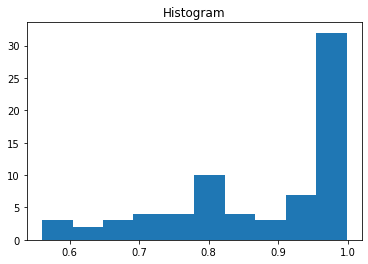

In [12]:
result_pkl[1][1][2].mean(axis = -1).mean(axis = -1).plot()